# Yelp Exploration

In [1]:
%matplotlib inline

from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import *
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import mixture
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
from nltk.stem import PorterStemmer

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

C:\Users\David\Anaconda3\envs\py3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\David\Anaconda3\envs\py3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\David\Anaconda3\envs\py3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  fr

In [21]:
%%time
# reviews = pd.read_csv('input/yelp_review.csv') # will take over 2 minutes
reviews = pd.read_csv('input/yelp_review.csv', nrows=10000) # essentially instant

Wall time: 117 ms


In [22]:
%%time
businesses = pd.read_csv('input/yelp_business.csv')

Wall time: 908 ms


In [23]:
%%time
attributes = pd.read_csv('input/yelp_business_attributes.csv', 
                             dtype='category', na_values='Na', true_values='True', false_values='False')
attribute_names = attributes.drop('business_id', axis=1).columns
attributes[attribute_names] = attributes[attribute_names].apply(lambda x: x.cat.codes)

Wall time: 3.44 s


In [24]:
joined = businesses.merge(attributes, on='business_id').set_index('business_id')
joined.head()

,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService
business_id,,,,,,,,,,,,,,,,,,,,,
FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## PCA analysis for the attributes database

Explained variance by component


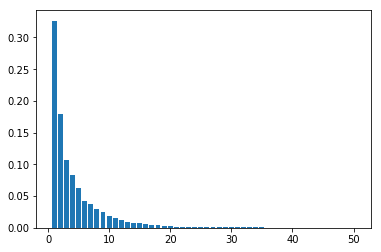


Explained variance up to...


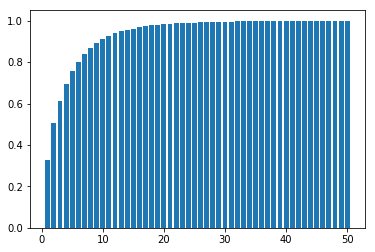

In [25]:
y_atts = pd.Series([int(x) for x in joined['stars']]) #round star ratings
x_atts = joined[joined.columns[12:]] #all the business attributes
x_atts_train, x_atts_dev, y_atts_train, y_atts_dev = train_test_split(x_atts, y_atts, test_size=.2, random_state=0)
pca = PCA()
pca.fit(x_atts_train)
print('Explained variance by component')
plt.bar(height = pca.explained_variance_ratio_[0:50], x = list(range(1,51)))
plt.show()
accrued = []
print()
print('Explained variance up to...')
for k in range(1,51):
    accrued.append(reduce(lambda x,y: x + y, pca.explained_variance_ratio_[0:k]))
plt.bar(height = accrued, x = list(range(1,51)))    
plt.show()

### I'm gonna check the factor loadings. If I have m components and p features, then this pxm matrix is the covariance between my feature matrix and my principal components. This way we can check which attributes are correlated with the most important components and get a proxy of which features are most important.

Graphic representation of the attributes more correlated with the component factors


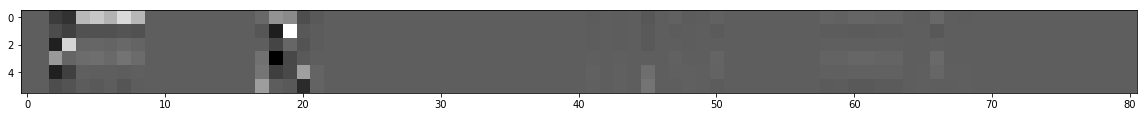

In [26]:
pca = PCA(n_components = 6)
pca.fit(x_atts_train)
factor_loadings = pca.components_.T*np.sqrt(pca.explained_variance_)
print('Graphic representation of the attributes more correlated with the component factors')
plt.figure(figsize=(20,10))
plt.imshow(factor_loadings.T, cmap='gray', interpolation='none')
plt.show()

In [27]:
df_fl = pd.DataFrame(factor_loadings, index = x_atts.columns.values, columns = range(1,7))
print('Ten most important attributes')
print(df_fl.applymap(abs).mean(axis = 1).sort_values(ascending = False)[0:10])

Ten most important attributes
WheelchairAccessible          0.219451
BikeParking                   0.212065
BusinessAcceptsCreditCards    0.205584
BusinessParking_garage        0.197441
BusinessParking_valet         0.143453
Alcohol                       0.125690
BusinessParking_validated     0.118410
BusinessParking_street        0.102108
GoodForKids                   0.100030
HairSpecializesIn_coloring    0.099475
dtype: float64


0


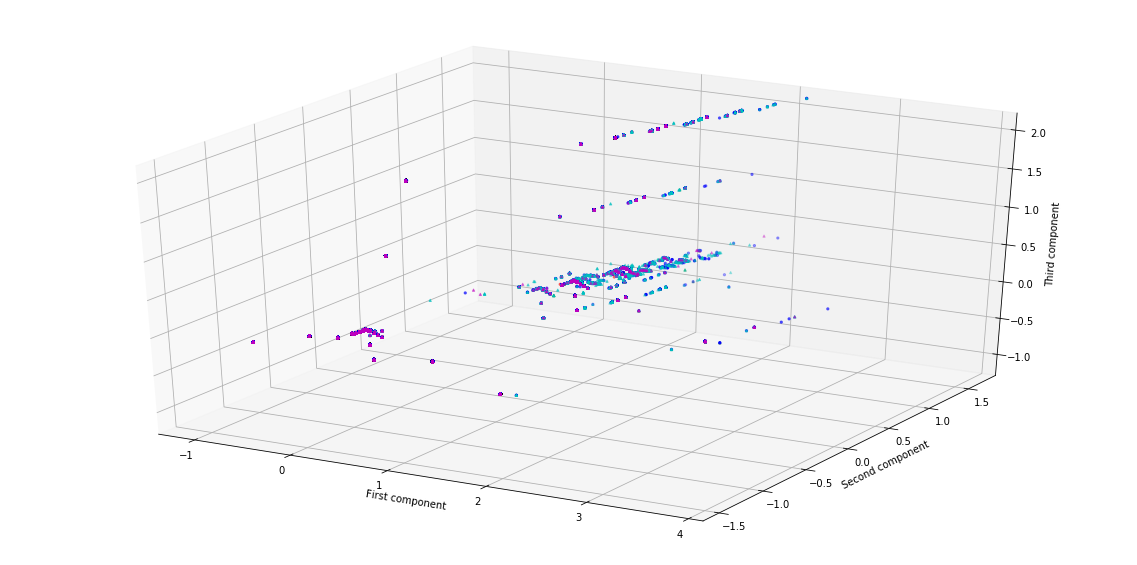

In [28]:
pca = PCA(n_components = 3)
td = pca.fit_transform(x_atts_train)
star_1 = td[y_atts_train == 1]
star_2 = td[y_atts_train == 2]
star_3 = td[y_atts_train == 3]
star_4 = td[y_atts_train == 4]
star_5 = td[y_atts_train == 5]
print(star_1.shape[0]+star_2.shape[0]+star_3.shape[0]+star_4.shape[0]+star_5.shape[0]-td.shape[0]) #check that calculations are correct

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

for c, m, star in [('r', 'o', star_1), ('g', '^', star_2), ('b', 'o', star_3), ('c', '^', star_4), ('m', '^', star_5)]:
    xs = star[:,0]
    ys = star[:,1]
    zs = star[:,2]
    ax.scatter(xs, ys, zs, c=c, marker=m, s=5, zdir = 'x')

ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.set_zlabel('Third component')

plt.show()

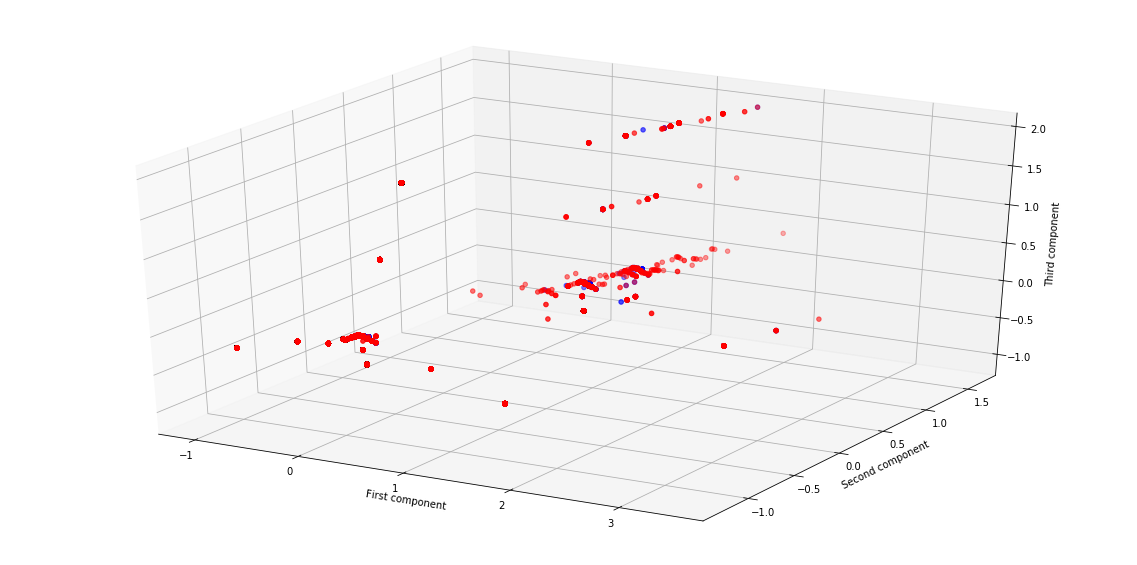

In [29]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

for c, m, star in [('b', 'o', star_1), ('r', 'o', star_5)]:
    xs = star[:,0]
    ys = star[:,1]
    zs = star[:,2]
    ax.scatter(xs, ys, zs, c=c, marker=m, s=20, zdir = 'x')

ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.set_zlabel('Third component')

plt.show()

Visually, it doesn't seems that there's a way to separate the star rating by the content of the attributes. But it could be that there is a solution in higher dimensions or using non linear models.

## Predictive model using only PCA components

## Gaussian mixtures

#### Data will be binarized by setting 1-2 as 1 and 4-5 as 5, 3s are dropped from the sample.

In [30]:
cov_mat = ['spherical', 'diag', 'tied', 'full']
n_GMM = [6,4,3,2]
acc = []
y_atts_dev = y_atts_dev.reset_index(drop = True)
x_atts_dev = x_atts_dev.reset_index(drop = True)
bin_y_atts_dev = y_atts_dev[(y_atts_dev<3) | (y_atts_dev>3)].apply(lambda x: 1 if x <3 else 5)
bin_x_atts_dev = x_atts_dev[(y_atts_dev<3) | (y_atts_dev>3)]

for k in range(0,len(cov_mat)):
    for i in range(0,len(n_GMM)):
        pca = PCA(n_components = 6)
        td = pca.fit_transform(x_atts_train)
        neg = td[y_atts_train < 3]
        pos = td[y_atts_train > 3]
        tst = pca.fit_transform(bin_x_atts_dev)
        clf = mixture.GaussianMixture(n_components = n_GMM[i], covariance_type = cov_mat[k], random_state = 0)
        clf_td_pos = clf.fit(pos)
        tst_mat_pos = np.exp(clf_td_pos.score_samples(tst))
        clf_td_neg = clf.fit(neg)
        tst_mat_neg = np.exp(clf_td_neg.score_samples(tst))
        y_pred = [5 if tst_mat_pos[j] > tst_mat_neg[j] else 1 for j in range(0,len(tst_mat_pos))]
        num = [1 if y_pred[j] == bin_y_atts_dev.iloc[j] else 0 for j in range(0,len(y_pred))]
        acc.append(sum(num)/len(y_pred))
mx = acc.index(max(acc))
a = mx//4
b = mx-a*4
print('Maximum accuracy was ', acc[mx], "\n", "It was achieved using 6 PCA components, ", n_GMM[b], " GMM components, with a ", cov_mat[a], " covariance matrix.")

Maximum accuracy was  0.6666992330614039 
 It was achieved using 6 PCA components,  4  GMM components, with a  full  covariance matrix.


## Support Vector Machine

In [31]:
#Using all labels
print('All labels')
svc = LinearSVC()
svc.fit(td, y_atts_train)
tst = pca.fit_transform(x_atts_dev)
print(metrics.classification_report(y_atts_dev, svc.predict(tst)))
print()
print('Binarized data')
bin_td = td[(y_atts_train<3) | (y_atts_train>3)]
bin_y_atts_train = y_atts_train[(y_atts_train<3) | (y_atts_train>3)].apply(lambda x: 1 if x <3 else 5)
svc.fit(bin_td, bin_y_atts_train)
bin_tst = pca.fit_transform(bin_x_atts_dev)
print(metrics.classification_report(bin_y_atts_dev, svc.predict(bin_tst)))


All labels


c:\users\sm_fe\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          1       0.00      0.00      0.00      1092
          2       0.00      0.00      0.00      4257
          3       0.38      0.29      0.33      9938
          4       0.35      0.69      0.47     10633
          5       0.35      0.17      0.23      4489

avg / total       0.30      0.36      0.31     30409


Binarized data
             precision    recall  f1-score   support

          1       0.51      0.02      0.04      5349
          5       0.74      0.99      0.85     15122

avg / total       0.68      0.74      0.64     20471



## Gaussian Naive Bayes

In [32]:
gnb = GaussianNB()
gnb = gnb.fit(td, y_atts_train)
y_pred = gnb.predict(tst)
print("Classification report for GaussianNB - All labels")
print(metrics.classification_report(y_atts_dev,y_pred))
gnb = gnb.fit(bin_td, bin_y_atts_train)
y_pred = gnb.predict(bin_tst)
print("Classification report for GaussianNB - Binarized data")
print(metrics.classification_report(bin_y_atts_dev,y_pred))

Classification report for GaussianNB - All labels
             precision    recall  f1-score   support

          1       0.09      0.04      0.06      1092
          2       0.17      0.07      0.10      4257
          3       0.42      0.38      0.40      9938
          4       0.38      0.36      0.37     10633
          5       0.28      0.54      0.36      4489

avg / total       0.34      0.34      0.33     30409

Classification report for GaussianNB - Binarized data
             precision    recall  f1-score   support

          1       0.33      0.10      0.16      5349
          5       0.74      0.93      0.83     15122

avg / total       0.64      0.71      0.65     20471



## Decision Tree

In [33]:
%%time

dt = DecisionTreeClassifier()
dt.fit(td, y_atts_train)
print("Classification report for Decision Tree - All labels")
print(metrics.classification_report(y_atts_dev, dt.predict(tst)))
dt.fit(bin_td, bin_y_atts_train)
print("Classification report for Decision Tree - Binarized data")
print(metrics.classification_report(bin_y_atts_dev, dt.predict(bin_tst)))

Classification report for Decision Tree - All labels
             precision    recall  f1-score   support

          1       0.11      0.00      0.00      1092
          2       0.15      0.16      0.15      4257
          3       0.37      0.22      0.27      9938
          4       0.37      0.59      0.45     10633
          5       0.30      0.20      0.24      4489

avg / total       0.32      0.33      0.30     30409

Classification report for Decision Tree - Binarized data
             precision    recall  f1-score   support

          1       0.27      0.18      0.22      5349
          5       0.74      0.83      0.78     15122

avg / total       0.62      0.66      0.63     20471

Wall time: 203 ms


## Random Forest

In [34]:
%%time

rf = RandomForestClassifier()
rf.fit(td, y_atts_train)
print("Classification report for Random Forest - All labels")
print(metrics.classification_report(y_atts_dev, rf.predict(tst)))
rf.fit(bin_td, bin_y_atts_train)
print("Classification report for Random Forest - Binarized data")
print(metrics.classification_report(bin_y_atts_dev, rf.predict(bin_tst)))

Classification report for Random Forest - All labels
             precision    recall  f1-score   support

          1       0.00      0.00      0.00      1092
          2       0.14      0.14      0.14      4257
          3       0.35      0.34      0.35      9938
          4       0.36      0.47      0.41     10633
          5       0.34      0.20      0.25      4489

avg / total       0.31      0.33      0.31     30409

Classification report for Random Forest - Binarized data
             precision    recall  f1-score   support

          1       0.27      0.15      0.19      5349
          5       0.74      0.85      0.79     15122

avg / total       0.62      0.67      0.64     20471

Wall time: 755 ms


In [35]:
%%time

lr = LogisticRegression(penalty='l1', C=2)
lr.fit(td, y_atts_train)
print("Classification report for Logistic regression - All labels")
print(metrics.classification_report(y_atts_dev, lr.predict(tst)))
lr.fit(bin_td, bin_y_atts_train)
print("Classification report for Logistic regression - Binarized data")
print(metrics.classification_report(bin_y_atts_dev, lr.predict(bin_tst)))

Classification report for Logistic regression - All labels
             precision    recall  f1-score   support

          1       0.00      0.00      0.00      1092
          2       0.00      0.00      0.00      4257
          3       0.38      0.29      0.33      9938
          4       0.35      0.69      0.47     10633
          5       0.35      0.17      0.23      4489

avg / total       0.30      0.36      0.31     30409

Classification report for Logistic regression - Binarized data
             precision    recall  f1-score   support

          1       0.51      0.02      0.04      5349
          5       0.74      0.99      0.85     15122

avg / total       0.68      0.74      0.64     20471

Wall time: 549 ms


c:\users\sm_fe\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### End of Sergio's section, this will look a lot more organized when we merge the different bits of code...

## EDA

Before starting the supervised machine learning, let us do some basic exploratory data analysis.  First let's take a look at what information we have in the `reviews` data frame.

In [36]:
reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


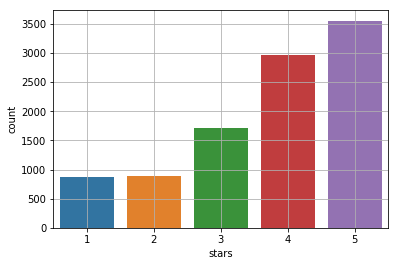

In [37]:
sns.countplot('stars', data=reviews)
plt.grid()
plt.show()

There is some right skew in the star ratings.  We will leave this alone for now and come back to it in the **Predicting Stars with Review Text** section.

For geographical separation.  We can run KMeans or put this on a maps API later.

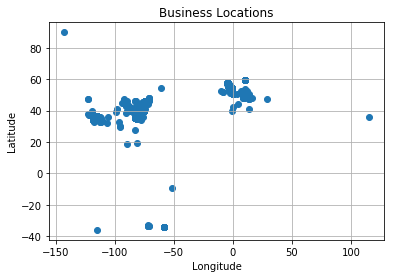

In [38]:
plt.scatter(businesses.longitude, businesses.latitude)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Business Locations')
plt.grid()
plt.show()

We're going to join businesses and attributes now.  Businesses without listed attributes and the converse will be excluded by the inner join.

In [39]:
joined = businesses.merge(attributes, on='business_id').set_index('business_id')
joined.head()

,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService
business_id,,,,,,,,,,,,,,,,,,,,,
FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## Extracting Categories

The categories in the `businesses` data frame is useful to us.  However, it is currently in the form of semicolon separated values.  In addition, the categories for each business do not seem to be ordered in any way.  Consider that restaurants are probably the most popular type of business on Yelp, but the "restaurant" label is not necessarily first (or even near the top) of the category list for any given applicable business.  Therefore, we will do some preprocessing to extract all the categories and sort them by popularity, i.e. frequency of appearance in businesses.

In [40]:
c = Counter()
joined.categories.str.split(';').apply(lambda x: c.update(x))

print('Total number of business: %d' % joined.shape[0])

n_categories = len(c.keys())
print('Total number of categories: %d' % n_categories)

Total number of business: 152041
Total number of categories: 1269


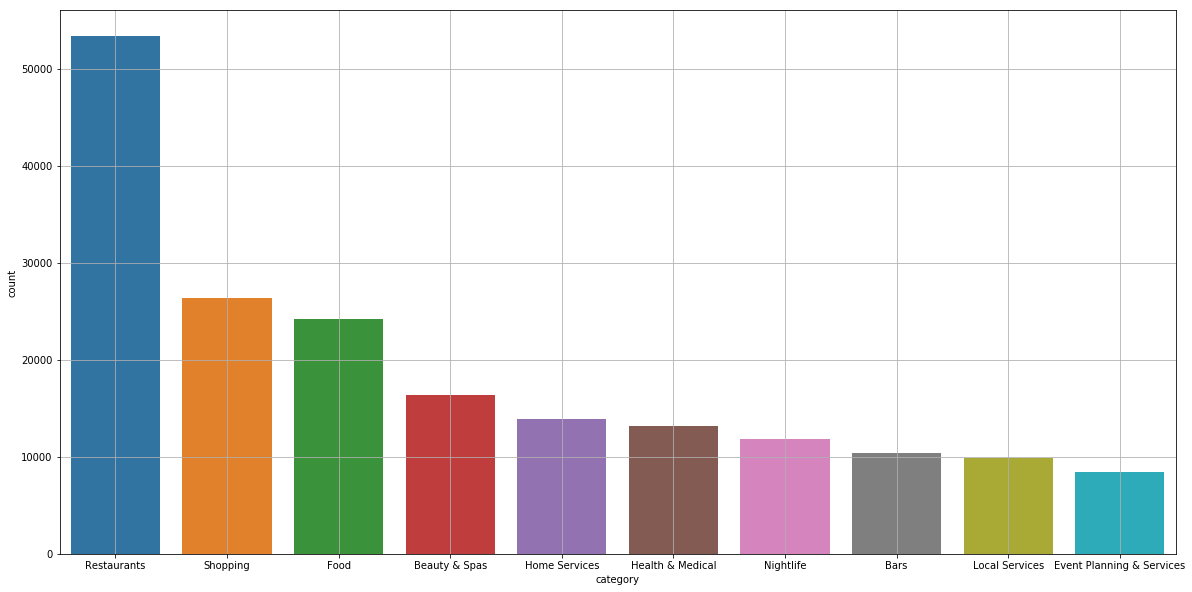

In [41]:
categories = pd.DataFrame.from_dict(c, orient='index').reset_index()
categories.columns = ['category', 'count']
categories = categories.sort_values('count', ascending=False)

plt.figure(figsize=[20,10])
sns.barplot(x='category', y='count', data=categories.iloc[:10])
plt.grid()
plt.show()

Unsurprisingly, the most popular category is restaurants by quite a large margin.

Now, we want to pull out the first few categories as "main categories for each business.  To do this, we

1. Split the categories
2. Sort the categories by descending count
3. Rejoin the categories
4. Split the categories into separate columns
5. Extract the first 3 columns

Admitedly, there seems to be some inefficiency between steps 3 and 4.  I am currently unsure of how to do it better.

In [42]:
main_categories = joined.categories.str.split(';')\
    .apply(lambda row: ';'.join(sorted(row, key=lambda x:-c[x]))).\
    str.split(';', expand=True)\
    [[0,1,2]]

main_categories.columns = ['category1', 'category2', 'category3']
attributes_categories = pd.concat([joined, main_categories], axis=1)
attributes_categories.head()

,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,...,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService,category1,category2,category3
business_id,,,,,,,,,,,,,,,,,,,,,
FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,...,-1,-1,-1,-1,-1,-1,-1,Health & Medical,Dentists,General Dentistry
He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,...,-1,-1,-1,-1,-1,-1,-1,Beauty & Spas,Hair Salons,Hair Stylists
8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,...,-1,-1,-1,-1,-1,-1,-1,Shopping,Sporting Goods,None
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,...,-1,-1,-1,-1,-1,-1,-1,Restaurants,Nightlife,Bars
o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,...,-1,-1,-1,-1,-1,-1,-1,Restaurants,Italian,None


## Machine Learning

### Predicting Stars with Business Attributes

We start our supervised learning first with exploring the possibility of predicting business ratings with its attributes.

In [43]:
np.random.seed(0)
X_train_attr, X_test_attr, y_train_attr, y_test_attr = \
    train_test_split(joined[attribute_names].values, joined.stars.astype(np.int8).values, test_size=.1)

#### Decision Tree

In [44]:
%%time

dt = DecisionTreeClassifier()
dt.fit(X_train_attr, y_train_attr)

print(metrics.classification_report(y_test_attr, dt.predict(X_test_attr), digits=3))

             precision    recall  f1-score   support

          1      0.333     0.002     0.004       528
          2      0.429     0.041     0.075      2130
          3      0.419     0.386     0.402      4992
          4      0.371     0.632     0.467      5275
          5      0.368     0.228     0.282      2280

avg / total      0.393     0.386     0.347     15205

Wall time: 1.04 s


#### Random Forest

In [45]:
%%time

rf = RandomForestClassifier()
rf.fit(X_train_attr, y_train_attr)

print(metrics.classification_report(y_test_attr, rf.predict(X_test_attr), digits=3))

             precision    recall  f1-score   support

          1      0.000     0.000     0.000       528
          2      0.438     0.041     0.076      2130
          3      0.420     0.387     0.403      4992
          4      0.371     0.633     0.468      5275
          5      0.368     0.228     0.282      2280

avg / total      0.383     0.387     0.348     15205

Wall time: 1.76 s


c:\users\sm_fe\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Naive Bayes

In [46]:
%%time

nb = MultinomialNB()
nb.fit(X_train_attr+1, y_train_attr) # have to add 1 to X_train_attr because NB doesn't like negative numbers

print(metrics.classification_report(y_test_attr, nb.predict(X_test_attr+1), digits=3))

             precision    recall  f1-score   support

          1      0.104     0.036     0.054       528
          2      0.313     0.087     0.137      2130
          3      0.426     0.380     0.402      4992
          4      0.392     0.406     0.399      5275
          5      0.291     0.576     0.387      2280

avg / total      0.367     0.365     0.349     15205

Wall time: 111 ms


### Predicting Stars with Review Text

In this section we will predict the star rating associated with each review text.  First, here is some reminder of what the reviews look like overall.  Recall that this data from only the first 10000 rows of data.  However, we have no reason to believe that the entire reviews dataset is not homogeneous.

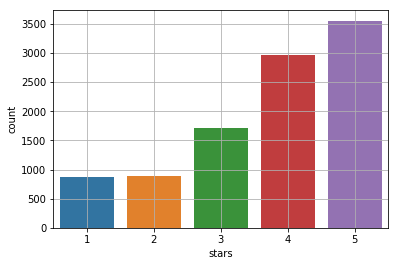

Mean star rating: 3.74


In [47]:
sns.countplot(reviews.stars)
plt.grid()
plt.show()

print('Mean star rating: %.2f' % reviews.stars.mean())

Star ratings tend to be skewed left and the average star rating is 3.74.  If humans were better at rating things objectively, we'd expect an average star rating around 2.5.

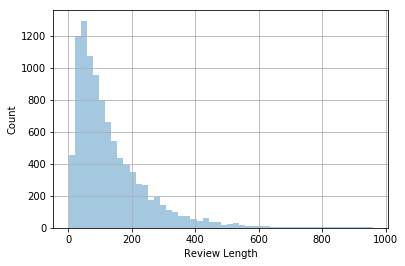

Mean review length: 133.74


In [3]:
reviews['word_count'] = reviews.text.str.split().apply(len)

sns.distplot(reviews.word_count, kde=False)
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.grid()
plt.show()

print('Mean review length: %.2f' % reviews.word_count.mean())

Unsurprisingly, review lengths are skewed right.  Most people are just leaving short blurbs, while a select emotioned individuals are writing essays.  Let's take a look at an example of a review from each star rating.  We'll just look at short ones for now, so we don't have to read any of the aforementioned essays.

In [9]:
def get_random_review(star, max_length=150):
    return reviews[(reviews.stars == star) & (reviews.word_count < max_length)].sample(1).text.values[0]

np.random.seed(4)
for star in range(1,6):
    print('%d star review:' % star)
    print(get_random_review(star))
    print('\n\n\n')

1 star review:
This place is not my favorite pest control. Even with the coupon you get very little service for your money. They are not eager to stand by the service and refused to come out and retreat the areas of my home where there were signs of pests.  Unless I paid an additional $200!




2 star review:
Looks better than it tastes - appetising menu is let down by poor execution. 


Pros: 
Good selection of beers on tap and in tall cans, and reasonably priced.
Nice decor and ambiance - we were able to follow a Leafs game on TV but the volume was low enough to hold conversations. 
Service was cheerful and accommodating, if a bit slow (albeit it was a busy Saturday night). 

Cons: 
The food. My fries were cold - twice. The "carnivore" plate had little protein. The soft-shell crab sandwich was clearly undercooked. Really below par for a bar, let alone a "gastro-pub".




3 star review:
Nice place and of course a must-hit place for all college students in Madison. Go grab some beer an

Note that it is really not easy even for a human to discern between some of these reviews.  The difference between 1- and 5- star reviews is fairly obvious, but much less so between 2- and 3- or 3- and 4- star reviews.  Thus, we must temper our expectations for any machine learning algorithm accuracy.

Now we will split the data up to start on our algorithms.

In [50]:
np.random.seed(0)
X_train_review, X_test_review, y_train_review, y_test_review = \
    train_test_split(reviews.text.values, reviews.stars.values, test_size=.1)

We will start with both a count vectorizer and a TFIDF vectorizer and compare the results using a simple logistic regression model.

#### Count Vectorizer

In [51]:
%%time
cv = CountVectorizer(stop_words='english')
dtm_train = cv.fit_transform(X_train_review)
dtm_test = cv.transform(X_test_review)
print('Number of features from CountVectorizer: %d' % len(cv.get_feature_names()))

lr = LogisticRegression()
lr.fit(dtm_train, y_train_review)

print(metrics.classification_report(y_test_review, lr.predict(dtm_test), digits=3))

Number of features from CountVectorizer: 30044
             precision    recall  f1-score   support

          1      0.694     0.628     0.659        94
          2      0.377     0.299     0.333        87
          3      0.384     0.303     0.339       175
          4      0.460     0.513     0.485       300
          5      0.611     0.663     0.636       344

avg / total      0.513     0.520     0.515      1000

Wall time: 3.78 s


#### TFIDF Vectorizer

In [52]:
%%time
tv = TfidfVectorizer(stop_words='english')
dtm_train2 = tv.fit_transform(X_train_review)
dtm_test2 = tv.transform(X_test_review)
print('Number of features from TFIDFVectorizer: %d' % len(tv.get_feature_names()))

lr2 = LogisticRegression()
lr2.fit(dtm_train2, y_train_review)

print(metrics.classification_report(y_test_review, lr2.predict(dtm_test), digits=3))

Number of features from TFIDFVectorizer: 30044
             precision    recall  f1-score   support

          1      0.716     0.564     0.631        94
          2      0.276     0.333     0.302        87
          3      0.338     0.434     0.380       175
          4      0.491     0.527     0.508       300
          5      0.737     0.587     0.654       344

avg / total      0.551     0.518     0.529      1000

Wall time: 1.52 s


TFIDF has both a better F1 score and is faster.  We will continue just using TFIDF instead of keeping two vectorizers.

In [53]:
# rename some variables
dtm_train = dtm_train2
dtm_test = dtm_test2
lr = lr2

#### Optimizing Logistic Regression

We now do some searching for the best parameters for logistic regression in order to maximize accuracy.

In [54]:
%%time

lr = GridSearchCV(LogisticRegression(), {'penalty':['l1', 'l2'], 'C': [.02, .2, 2]})
lr.fit(dtm_train, y_train_review)
print('\nLogistic Regression, best parameters: ' + str(lr.best_params_))
print(metrics.classification_report(y_test_review, lr.predict(dtm_test), digits=3))


Logistic Regression, best parameters: {'C': 2, 'penalty': 'l1'}
             precision    recall  f1-score   support

          1      0.727     0.681     0.703        94
          2      0.419     0.207     0.277        87
          3      0.441     0.297     0.355       175
          4      0.476     0.533     0.503       300
          5      0.607     0.733     0.664       344

avg / total      0.534     0.546     0.532      1000

Wall time: 4.39 s


Next we explore an support vector classifier in place of a logistic regression one.

#### SVM

We will be using a linear SVC as the C-support SVC scales quadratically with training size, making it unfeasible to train on the entire reviews set.

In [55]:
%%time
svc = LinearSVC()
svc.fit(dtm_train, y_train_review)
print(metrics.classification_report(y_test_review, svc.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

          1      0.678     0.649     0.663        94
          2      0.382     0.241     0.296        87
          3      0.383     0.326     0.352       175
          4      0.453     0.497     0.474       300
          5      0.623     0.683     0.652       344

avg / total      0.514     0.523     0.516      1000

Wall time: 326 ms


In [56]:
%%time
svc = GridSearchCV(LinearSVC(), {'C': [.02, .2, 2]})
svc.fit(dtm_train, y_train_review)
print('\nSVC, best parameters: ' + str(svc.best_params_))
print(metrics.classification_report(y_test_review, svc.predict(dtm_test), digits=3))


SVC, best parameters: {'C': 0.2}
             precision    recall  f1-score   support

          1      0.706     0.638     0.670        94
          2      0.459     0.195     0.274        87
          3      0.431     0.286     0.344       175
          4      0.475     0.530     0.501       300
          5      0.614     0.762     0.680       344

avg / total      0.535     0.548     0.531      1000

Wall time: 1.53 s


The SVC performs slightly worse than logistic regression, but trains faster.

Naive Bayes is next.

#### Naive Bayes

In [57]:
%%time
nb = MultinomialNB()
nb.fit(dtm_train, y_train_review)
print(metrics.classification_report(y_test_review, nb.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

          1      0.000     0.000     0.000        94
          2      0.000     0.000     0.000        87
          3      0.000     0.000     0.000       175
          4      0.370     0.400     0.385       300
          5      0.442     0.869     0.586       344

avg / total      0.263     0.419     0.317      1000

Wall time: 16 ms


c:\users\sm_fe\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
%%time
nb = GridSearchCV(MultinomialNB(), {'alpha': [.002, .02, .2, 2]})
nb.fit(dtm_train, y_train_review)
print('\nMultinomial Naive Bayes, best parameters: ' + str(nb.best_params_))
print(metrics.classification_report(y_test_review, nb.predict(dtm_test), digits=3))


Multinomial Naive Bayes, best parameters: {'alpha': 0.02}
             precision    recall  f1-score   support

          1      0.630     0.489     0.551        94
          2      0.192     0.057     0.088        87
          3      0.364     0.246     0.294       175
          4      0.414     0.513     0.458       300
          5      0.569     0.680     0.620       344

avg / total      0.460     0.482     0.462      1000

Wall time: 203 ms


Naive Bayes works really poorly unless we decrease Laplace smoothing (default value is 1).  Even then, it performs significantly worse than SVC or logistic regression albeit at a much faster training time.

### Binarizing the Labels

It would be difficult for even a human to perfectly predict a review's star rating just from the text.  This is especially true for the middle star ratings, where language may be less dramatic.  Therefore, we will now divide all the reviews into two categories (negative and positive) and see how well machine learning can differentiate between the two.

We are going to filter out the 3 star reviews.  Then, we treat the 1- and 2-star reviews as negative; the 4- and 5-star reviews as positive.

In [3]:
extreme_reviews = reviews[['text', 'stars']][reviews.stars != 3]
extreme_reviews['positive'] = extreme_reviews.stars > 3
extreme_reviews.head()

,text,stars,positive
0,Super simple place but amazing nonetheless. It...,5,True
1,Small unassuming place that changes their menu...,5,True
2,Lester's is located in a beautiful neighborhoo...,5,True
3,Love coming here. Yes the place always needs t...,4,True
4,Had their chocolate almond croissant and it wa...,4,True


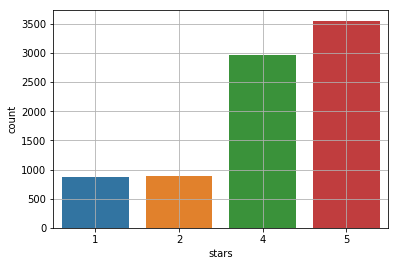

In [60]:
sns.countplot('stars', data=extreme_reviews)
plt.grid()
plt.show()

We will train the classifiers using the best parameters found in the previous sections.

In [4]:
np.random.seed(0)
X_train_review, X_test_review, y_train_review, y_test_review = \
    train_test_split(extreme_reviews.text.values, extreme_reviews.positive.values, test_size=.1)
    
tv = TfidfVectorizer(stop_words='english')
dtm_train = tv.fit_transform(X_train_review)
dtm_test = tv.transform(X_test_review)
print('Number of features from TFIDFVectorizer: %d' % len(tv.get_feature_names()))

Number of features from TFIDFVectorizer: 26985


In [62]:
%%time

lr = LogisticRegression(penalty='l1', C=2)
lr.fit(dtm_train, y_train_review)

print(metrics.classification_report(y_test_review, lr.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

      False      0.942     0.670     0.783       194
       True      0.907     0.987     0.946       635

avg / total      0.915     0.913     0.908       829

Wall time: 70.8 ms


In [63]:
%%time

svc = LinearSVC(C=.2)
svc.fit(dtm_train, y_train_review)

print(metrics.classification_report(y_test_review, svc.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

      False      0.952     0.608     0.742       194
       True      0.892     0.991     0.939       635

avg / total      0.906     0.901     0.893       829

Wall time: 33.9 ms


In [64]:
%%time

nb = MultinomialNB(alpha=.02)
nb.fit(dtm_train, y_train_review)

print(metrics.classification_report(y_test_review, nb.predict(dtm_test), digits=3))

             precision    recall  f1-score   support

      False      0.867     0.469     0.609       194
       True      0.858     0.978     0.914       635

avg / total      0.860     0.859     0.842       829

Wall time: 6.98 ms


As expected performance is now much better.  The algorithm is able to tell the difference between positive and negative reviews with over 90% accuracy in the case of logistic regression.  Logistic regression seems to be performing the best among the three candidate models, so we will continue with that.

### Optimizing the Vectorizer

Now that we have a classifier picked out, we will revisit the vectorizer to see if we can get any improvements by adjusting the paramenters.

In [73]:
%%time

pipe = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')), 
    ('clf', LogisticRegression(penalty='l1', C=2))
])

param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__max_df': [.25, .4, .8, 1.0],
    'vect__min_df': [0.0, .1, .2]
}

grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train_review, y_train_review)
print('\nBest parameters: ' + str(grid.best_params_))
#print(grid.grid_scores_)
print(metrics.classification_report(y_test_review, grid.predict(X_test_review), digits=3))


Best parameters: {'vect__max_df': 0.4, 'vect__min_df': 0.0, 'vect__ngram_range': (1, 1)}
[mean: 0.89698, std: 0.00466, params: {'vect__max_df': 0.25, 'vect__min_df': 0.0, 'vect__ngram_range': (1, 1)}, mean: 0.89457, std: 0.00487, params: {'vect__max_df': 0.25, 'vect__min_df': 0.0, 'vect__ngram_range': (1, 2)}, mean: 0.80617, std: 0.00478, params: {'vect__max_df': 0.25, 'vect__min_df': 0.1, 'vect__ngram_range': (1, 1)}, mean: 0.80617, std: 0.00478, params: {'vect__max_df': 0.25, 'vect__min_df': 0.1, 'vect__ngram_range': (1, 2)}, mean: 0.78940, std: 0.00013, params: {'vect__max_df': 0.25, 'vect__min_df': 0.2, 'vect__ngram_range': (1, 1)}, mean: 0.78940, std: 0.00013, params: {'vect__max_df': 0.25, 'vect__min_df': 0.2, 'vect__ngram_range': (1, 2)}, mean: 0.90034, std: 0.00184, params: {'vect__max_df': 0.4, 'vect__min_df': 0.0, 'vect__ngram_range': (1, 1)}, mean: 0.89805, std: 0.00181, params: {'vect__max_df': 0.4, 'vect__min_df': 0.0, 'vect__ngram_range': (1, 2)}, mean: 0.82200, std: 0.0

Note that we did did not get any noticeable improvement in F1.  However, we were able to get this score with with the maximum document frequency set 0.4.  That means we are ignoring the top *60%* of the most frequent words.

### Stemming

Let's see if we can push some more performance out by stemming the input.

In [66]:
ps = PorterStemmer()
def stem(s):
    return ' '.join(ps.stem(x) for x in s.split(' '))

In [67]:
%%time

tv_stem = TfidfVectorizer(stop_words='english', max_df=.4)
dtm_train_stem = tv_stem.fit_transform(map(stem, X_train_review))
dtm_test_stem = tv_stem.transform(map(stem, X_test_review))
print('Number of features from CountVectorizer: %d' % len(tv.vocabulary_))

lr_stem = LogisticRegression(penalty='l1', C=2)
lr_stem.fit(dtm_train_stem, y_train_review)

print(metrics.classification_report(y_test_review, lr_stem.predict(dtm_test_stem), digits=3))

Number of features from CountVectorizer: 26985
             precision    recall  f1-score   support

      False      0.929     0.675     0.782       194
       True      0.908     0.984     0.945       635

avg / total      0.913     0.912     0.907       829

Wall time: 16.2 s


Unfortunately, it looks like stemming did not help in this case.

### What Are we Actually Missing?

Let's take a look at the worst mistakes that the classifier is making see if we can't at least give some reason as to the mistakes.

In [68]:
num_examples = 5

pred = lr.predict(dtm_test)
prob = lr.predict_proba(dtm_test)
R = [(i, max(prob[i]), min(prob[i])) for i, y in enumerate(y_test_review) if y != pred[i]]
R.sort(key=lambda x: -x[1]/x[2])

for _ in range(num_examples):
    for (i, wrong_prob, right_prob) in R:
        if not num_examples: break
        num_examples -= 1
        
        print('Index:', i)
        print('Negative review probability: %3f' % prob[i][0])
        print('Positive review probability: %3f' % prob[i][1])
        print('\n')
        print(X_test_review[i])
        print('\n\n\n')
        

Index: 55
Negative review probability: 0.015847
Positive review probability: 0.984153


I enjoyed the atmosphere and the service was great. However, the food was drenched in oil and really left both my husband and I uninterested in returning. We were so hoping to love this place because as vegans, there are so few healthy restaurants in the valley.




Index: 559
Negative review probability: 0.071530
Positive review probability: 0.928470


When Turntable first opened, they were FANTASTIC! However, they have now gone the way of every other health care provider in the valley. Forget about reaching anyone or having any request taken care of in a timely manner. Used to be able to get same-day appointments - now I have to wait weeks to see anyone.  Some of the health coaches there seem to be sullen and angry - about what I'm not sure, but they are certainly not "coaches" any more. Now I see my primary doctor - Dr. Gokal - has left. He was wonderful. So now I'm wondering why I'm paying $80 a

We notice a lot of mistakes for reviews where the reviewer's expectation is stated but was not met.  We also see some language that may be hard to pick up by a machine learning algorithm (e.g. "did not like" is actually negative despite having the word "like" in it).  It seems that we need some sort of an algorithm that has a memory of what came before and after certain features.  Something like a recurrent neural network...

### Recurrent Neural Network

In this section we will implement a very simple recurrent neural network.  It will consist only 4 layers:
1. An embedding layer for an efficient representation of the training samples
2. A long short term memory layer for the bulk of the prediction power
3. A dropout layer for regularization
4. An output layer

We will also have a checkpoint callback for saving the model.

But first, we need to tokenize the input.  We will use the same number of features as the vocabulary from the TFIDF vectorizer. Also we will only use the first 200 words from each review in order to capture most of the reviews, whilte setting a reasonable limit (recall the below plot).

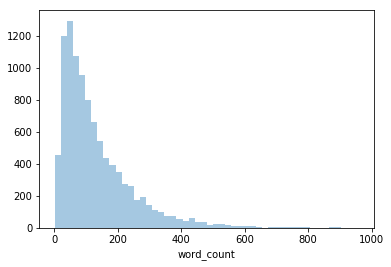

In [19]:
sns.distplot(reviews.word_count, kde=False)

In [6]:
max_features = len(tv.vocabulary_) # use same number of features as TFIDF vectorizer
maxlen = 200 # max words from each review to use

t = Tokenizer(num_words=max_features)
t.fit_on_texts(extreme_reviews['text'])
texts = pad_sequences(t.texts_to_sequences(extreme_reviews['text']), maxlen = maxlen)

Now we can build the model as described above.  We are essentially using the suggested LSTM network suggested [here](https://keras.io/getting-started/sequential-model-guide/).

In [31]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

try: model.load_weights('rnn_weights.hdf5') # load weights if they exist
except: pass

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath='rnn_weights.hdf5')

Create some new training and test sets.

In [8]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = \
    train_test_split(texts, extreme_reviews.positive.values, test_size=.1)

Train the model and output the accuracy.

In [32]:
model.fit(X_train_rnn, y_train_rnn, epochs=10, batch_size=64, callbacks=[checkpoint], validation_split=.1)

print('Test')
score = model.evaluate(X_test_rnn, y_test_rnn, batch_size=64)
print('Loss = %.4f' % score[0])
print('Accuracy = %.4f' % score[1])

Train on 6709 samples, validate on 746 samples
Epoch 1/10
6709/6709 [==============================] - 41s 6ms/step - loss: 0.1247 - acc: 0.9593 - val_loss: 0.1525 - val_acc: 0.9410
Epoch 2/10
6709/6709 [==============================] - 41s 6ms/step - loss: 0.0837 - acc: 0.9736 - val_loss: 0.1525 - val_acc: 0.9437
Epoch 3/10
6709/6709 [==============================] - 41s 6ms/step - loss: 0.0527 - acc: 0.9818 - val_loss: 0.2703 - val_acc: 0.9021
Epoch 4/10
6709/6709 [==============================] - 41s 6ms/step - loss: 0.0494 - acc: 0.9842 - val_loss: 0.3319 - val_acc: 0.9316
Epoch 5/10
6709/6709 [==============================] - 42s 6ms/step - loss: 0.0318 - acc: 0.9900 - val_loss: 0.2500 - val_acc: 0.9303
Epoch 6/10
6709/6709 [==============================] - 43s 6ms/step - loss: 0.0327 - acc: 0.9902 - val_loss: 0.2321 - val_acc: 0.9370
Epoch 7/10
6709/6709 [==============================] - 43s 6ms/step - loss: 0.0290 - acc: 0.9915 - val_loss: 0.3478 - val_acc: 0.9236
Epoch 8/

After quite a long time of training, we end up with performance that is not even as good as naive Bayes.  This is probably an artifact of the simplicity of the model.  Also we are not using very much training data here.

### Load more data

In this section we load some more data (10X what we've been developing with) and see how that affects the results.

In [3]:
more_reviews = pd.read_csv('input/yelp_review.csv', nrows=100000)

In [6]:
%%time
more_reviews['positive'] = more_reviews.stars > 3

np.random.seed(0)
X_train_review2, X_test_review2, y_train_review2, y_test_review2 = \
    train_test_split(more_reviews.text.values, more_reviews.positive.values, test_size=.1)
    
tv = TfidfVectorizer(stop_words='english')
dtm_train2 = tv.fit_transform(X_train_review2)
dtm_test2 = tv.transform(X_test_review2)
print('Number of features from TFIDFVectorizer: %d' % len(tv.get_feature_names()))

Number of features from TFIDFVectorizer: 83781
Wall time: 8.36 s


In [10]:
%%time

lr = LogisticRegression(penalty='l1', C=2)
lr.fit(dtm_train2, y_train_review2)

print(metrics.classification_report(y_test_review2, lr.predict(dtm_test2), digits=3))
print('Accuracy:', metrics.accuracy_score(y_test_review2, lr.predict(dtm_test2)))

             precision    recall  f1-score   support

      False      0.858     0.787     0.821      3326
       True      0.898     0.935     0.916      6674

avg / total      0.885     0.886     0.884     10000

Accuracy: 0.8858
Wall time: 2.2 s


In [13]:
%%time

max_features = 26985 # use same number of features as previous TFIDF vectorizer
maxlen = 200 # max words from each review to use

t = Tokenizer(num_words=max_features)
t.fit_on_texts(more_reviews['text'])
texts = pad_sequences(t.texts_to_sequences(more_reviews['text']), maxlen = maxlen)

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

try: model.load_weights('rnn_weights.hdf5') # load weights if they exist
except: pass

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath='rnn_weights.hdf5')

X_train_rnn2, X_test_rnn2, y_train_rnn2, y_test_rnn2 = \
    train_test_split(texts, more_reviews.positive.values, test_size=.1)

Wall time: 17.6 s


In [18]:
model.fit(X_train_rnn2, y_train_rnn2, epochs=10, batch_size=64, callbacks=[checkpoint], validation_split=.1)

print('Test')
score = model.evaluate(X_test_rnn2, y_test_rnn2, batch_size=64)
print('Loss = %.4f' % score[0])
print('Accuracy = %.4f' % score[1])

Train on 81000 samples, validate on 9000 samples
Epoch 1/10
81000/81000 [==============================] - 522s 6ms/step - loss: 0.1605 - acc: 0.9400 - val_loss: 0.2632 - val_acc: 0.9067
Epoch 2/10
81000/81000 [==============================] - 521s 6ms/step - loss: 0.1452 - acc: 0.9469 - val_loss: 0.2437 - val_acc: 0.9031
Epoch 3/10
81000/81000 [==============================] - 522s 6ms/step - loss: 0.1301 - acc: 0.9528 - val_loss: 0.2712 - val_acc: 0.9057
Epoch 4/10
81000/81000 [==============================] - 521s 6ms/step - loss: 0.1153 - acc: 0.9592 - val_loss: 0.2719 - val_acc: 0.9014
Epoch 5/10
81000/81000 [==============================] - 521s 6ms/step - loss: 0.1004 - acc: 0.9651 - val_loss: 0.3434 - val_acc: 0.8953
Epoch 6/10
81000/81000 [==============================] - 521s 6ms/step - loss: 0.0866 - acc: 0.9708 - val_loss: 0.3498 - val_acc: 0.8913
Epoch 7/10
81000/81000 [==============================] - 522s 6ms/step - loss: 0.0765 - acc: 0.9740 - val_loss: 0.3470 - v

Unfortunately we did not improve the accuracy on the logistic regression or neural network model.  Some work needs to be done on the structure of the neural network.